In [1]:
from google.colab import drive  
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
from numpy.linalg import pinv, cond
from sklearn.covariance import LedoitWolf

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px

from yellowbrick.cluster import KElbowVisualizer
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


In [4]:
CLEAN_FILE_PATH = '/content/gdrive/MyDrive/proyecto-integrador-grupo1/proyecto-integrador-data/marketing_campaign_clean.csv'
CLUSTERED_FILE_PATH = '/content/gdrive/MyDrive/proyecto-integrador-grupo1/proyecto-integrador-data/marketing_campaign_clustered.csv'

NUMERIC_CLUSTERING_FIELDS = ['User_Age', 'Income', 'Child_Count', 'Day_Cnt',
                                'Recency', 'Purchases_Z1', 'Purchases_Z2', 
                                'Purchases_Z3']

BINARY_CLUSERTING_FIELDS = ['Marital_Status_Joined', 'Education_Graduate', 
                            'Education_Postgraduate', 'AcceptedCmp3', 
                            'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 
                            'AcceptedCmp2', 'Complain','Response']

OMITTED_FIELDS = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                  'MntSweetProducts', 'MntGoldProds', 'Spent']

CLUSTERING_FIELDS = NUMERIC_CLUSTERING_FIELDS + BINARY_CLUSERTING_FIELDS

full_df = pd.read_csv(CLEAN_FILE_PATH)

num_cluster_df = full_df[NUMERIC_CLUSTERING_FIELDS]
scaler = StandardScaler()
scaler.fit(num_cluster_df)

num_cluster_df = scaler.transform(num_cluster_df)
num_cluster_df = pd.DataFrame(num_cluster_df)
num_cluster_df.columns = NUMERIC_CLUSTERING_FIELDS

cluster_df = pd.concat(
    [num_cluster_df, full_df[BINARY_CLUSERTING_FIELDS]], axis=1)

cluster_df.head()

,User_Age,Income,Child_Count,Day_Cnt,Recency,Purchases_Z1,Purchases_Z2,Purchases_Z3,Marital_Status_Joined,Education_Graduate,Education_Postgraduate,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1.007629,0.500913,-1.257809,1.534232,0.320574,-1.119809,0.963413,0.248096,0,1,0,0,0,0,0,0,0,1
1,1.263009,-0.111161,1.398639,-1.176232,-0.372909,0.826723,-0.774694,0.939452,0,1,0,0,0,0,0,0,0,0
2,0.326614,1.200225,-1.257809,-0.195537,-0.788999,-1.189952,0.054285,-2.200314,1,1,0,0,0,0,0,0,0,0
3,-1.290795,-1.133429,0.070415,-1.048101,-0.788999,0.739024,-0.345211,0.050292,1,1,0,0,0,0,0,0,0,0
4,-1.035415,0.508957,0.070415,-0.939682,1.568843,-0.346741,0.990842,1.302939,1,0,1,0,0,0,0,0,0,0


In [5]:
def assign_buckets(datum, min_num, max_num, bucket_count):
    datum -= min_num
    bucket_size = (max_num - min_num) / bucket_count
    return int(datum / bucket_size)


cov = LedoitWolf().fit(num_cluster_df)
d_cov = cov.covariance_
d_inv_cov = np.linalg.pinv(d_cov)
print('d_cov COND', cond(d_cov))
def mahalanobis(x, y):
    return (x - y).T.dot(d_inv_cov).dot(x - y)


def hamman(x, y):
    conf_mat = [0, 0, 0, 0]
    for i in range(len(NUMERIC_CLUSTERING_FIELDS), len(x)):
        conf_mat[0] += x[i] == 1 and y[i] == 1 # a
        conf_mat[1] += x[i] == 1 and y[i] == 0 # b
        conf_mat[2] += x[i] == 0 and y[i] == 1 # c
        conf_mat[3] += x[i] == 0 and y[i] == 0 # d

    # Hamman para evitar denominador con 0 
    hamman_num = (conf_mat[0] + conf_mat[3]) - (conf_mat[1] + conf_mat[2]) 
    hamman_den = conf_mat[0] + conf_mat[1] + conf_mat[2] + conf_mat[3]

    return hamman_num / hamman_den
    
    
def mixed_metric(x, y):
    x_cont = x[0:len(NUMERIC_CLUSTERING_FIELDS)]
    y_cont = y[0:len(NUMERIC_CLUSTERING_FIELDS)]


    # euclidean_dist = ((x_cont - y_cont).T.dot(x_cont - y_cont)) ** (1/2)    
    mahalanobis_dist = mahalanobis(x_cont, y_cont)
    hamman_dist = hamman(x, y)    

    # return euclidean_dist + hamman_dist
    return mahalanobis_dist + hamman_dist


def count_percent(col, tags):
    total_tag = {}
    tag_col_count = {}

    for i in range(len(col)):
        tag = tags.iloc[i]
        val = col.iloc[i]

        if tag not in total_tag:
            total_tag[tag] = 0
            tag_col_count[tag] = {}

        if val not in tag_col_count[tag]:
            tag_col_count[tag][val] = 0
        
        total_tag[tag] += 1
        tag_col_count[tag][val] += 1

    res = []
    for tag in tag_col_count:
        res.append([])
        for val, count in tag_col_count[tag].items():
            tag_col_count[tag][val] = count / total_tag[tag]
            res[-1].append(count / total_tag[tag])


    return (tag_col_count, res) 


def make_pie_chart(cluster_percents, names_labels, name):
    pie_chart_figs = []
    for clust_ind, clust_ages in cluster_percents.items():
        pie_chart_figs.append(plt.figure())
        plt.title(f"Cluster #{clust_ind}")
        
        labels_vals = list(clust_ages.items())
        labels_vals.sort()

        labels = [f"{l}({k: .2f}): {v: .2f}" for l, (k, v) in zip(names_labels, labels_vals)]
        vals  = [ v for _, v in labels_vals]

        plt.pie(vals, labels = labels)
        plt.savefig(f"pie_chart_{name}_cluster{clust_ind}_kmedoids.png", bbox_inches='tight')


d_cov COND 10.965353111100026


In [6]:
def get_pie_graphs(cluster_df, full_df):
    (clust_percents_age, _) = count_percent(
    full_df['Age_Group'], cluster_df['Clusters'])
    PIE_CHART_AGE_LABELS = ['Youngest', 'Adult', 'Oldest']
    make_pie_chart(clust_percents_age, PIE_CHART_AGE_LABELS, 'age_group')



    (clust_percents_child, _) = count_percent(
        cluster_df['Child_Count'], cluster_df['Clusters'])
    PIE_CHART_CHILD_LABELS = ['Fewest Children', 'Few Children', 'Many Children', 
                            'Most Children' ]
    make_pie_chart(clust_percents_child, PIE_CHART_CHILD_LABELS, 'child_count')


    PIE_CHART_EDUCATION_LABELS = ['No Graduate Studies', 'Graduate Studies', 
                                  'Post-Graduate Studies', 'Both']
    (clust_percents_education, _) = count_percent(
        full_df['Cumulative_Education'], cluster_df['Clusters'])
    make_pie_chart(clust_percents_education, PIE_CHART_EDUCATION_LABELS,
                   'cumulative_education')


def get_box_plots(cluster_df, full_df):
    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Spent"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Spent"])
    plt.savefig('boxplot_spent_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Income"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Income"])
    plt.savefig('boxplot_income_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Day_Cnt"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Day_Cnt"])
    plt.savefig('boxplot_day_cnt_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["User_Age"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["User_Age"])
    plt.savefig('boxplot_user_age_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Recency"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Recency"])
    plt.savefig('boxplot_recency_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z1"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z1"])
    plt.savefig('boxplot_purchase_z1_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z2"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z2"])
    plt.savefig('boxplot_purchase_z2_kmedoids.png', bbox_inches='tight')

    plt.figure()
    pl=sns.swarmplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z3"], alpha=0.5 )
    pl=sns.boxenplot(x=cluster_df['Clusters'], y=full_df["Purchases_Z3"])
    plt.savefig('boxplot_purchase_z3_kmedoids.png', bbox_inches='tight')


def get_scatter_plots(cluster_df, full_df):
    fig2 = plt.figure()
    clust_scatter2 = sns.scatterplot(x=cluster_df['Income'], y=full_df['Spent'],
                                    hue=cluster_df['Clusters'])

    plt.savefig('scatterplot_income_spent_kmedoids.png', bbox_inches='tight')

    fig3 = plt.figure()
    clust_scatter3 = sns.scatterplot(x=cluster_df['User_Age'],
                                    y=cluster_df['Income'],
                                    hue=cluster_df['Clusters'])
    plt.savefig('scatterplot_user_age_income_kmedoids.png', bbox_inches='tight')
    
    fig4 = plt.figure()
    clust_scatter4 = sns.scatterplot(x=cluster_df['User_Age'],
                                    y=full_df['Spent'],
                                    hue=cluster_df['Clusters'])

    plt.savefig('scatterplot_user_age_spent_kmedoids.png', bbox_inches='tight')


In [7]:
full_df["Total_Promos"] = full_df["AcceptedCmp1"]+ full_df["AcceptedCmp2"] \
                            + full_df["AcceptedCmp3"]+ full_df["AcceptedCmp4"] \
                            + full_df["AcceptedCmp5"]

full_df["Cumulative_Education"] = full_df["Education_Graduate"] \
                                    + (2 * full_df["Education_Postgraduate"])
                            

max_value = full_df['User_Age'].max() + 1 # force an upper bound in the groups
min_value = full_df['User_Age'].min()
print(min_value, max_value)
full_df['Age_Group'] = full_df['User_Age'].apply(
    lambda x: assign_buckets(x, min_value, max_value, 3))


# K-Medoids
# https://towardsdatascience.com/k-medoid-clustering-pam-algorithm-in-python-with-solved-example-c0dcb35b3f46
# https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
MAX_KMEDOIDS_K = 8
KMEDOIDS_METRIC = mixed_metric

18 75


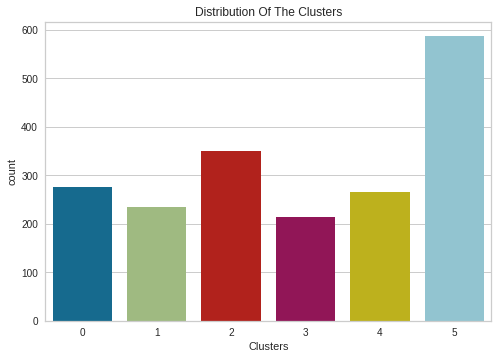

In [8]:
# K-Medoids para clustering con elbow
# Correr estas 3 lineas puede demorarse mas de 30 mins
# Elbow_M = KElbowVisualizer(KMedoids(metric=KMEDOIDS_METRIC), k=MAX_KMEDOIDS_K)
# Elbow_M.fit(cluster_df)
# Elbow_M.show()

ELBOW_OPTIMAL_K = 6


# K-Medoids para clustering con silhouette
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# sil = []
# for k in range(2, MAX_KMEDOIDS_K):
#     print(k)
#     kmeans = KMedoids(metric=KMEDOIDS_METRIC, n_clusters = k).fit(cluster_df)
#     labels = kmeans.labels_
#     curr_sil_score = silhouette_score(cluster_df, labels, metric=KMEDOIDS_METRIC)
#     sil.append(curr_sil_score)
  
# plt.plot(list(range(2, MAX_KMEDOIDS_K)), sil)
# SIL_OPTIMAL_K = 2

# kmdeoids with elbow method optimum
kmedoids_elbow = KMedoids(n_clusters = ELBOW_OPTIMAL_K)
kmedoids_elbow.fit(cluster_df)
cluster_df['Clusters'] = kmedoids_elbow.labels_

fig1 = plt.figure()
clust_dist = sns.countplot(x=cluster_df['Clusters'])
clust_dist.set_title("Distribution Of The Clusters")

plt.show()



# print dataframe to csv
base_df = pd.read_csv(CLEAN_FILE_PATH, index_col=0)
base_df =  pd.concat([base_df, cluster_df['Clusters']], axis=1)
base_df.to_csv(CLUSTERED_FILE_PATH)

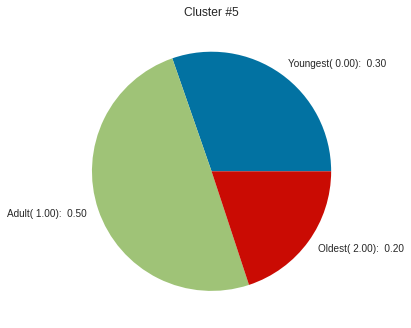

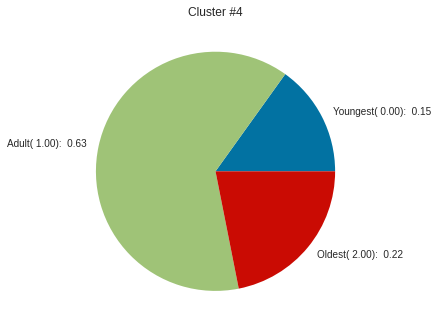

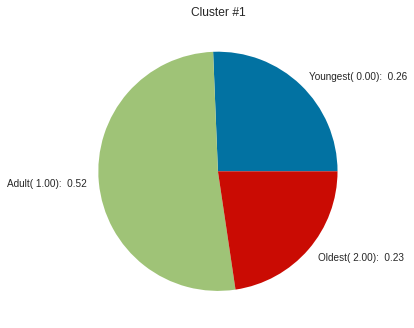

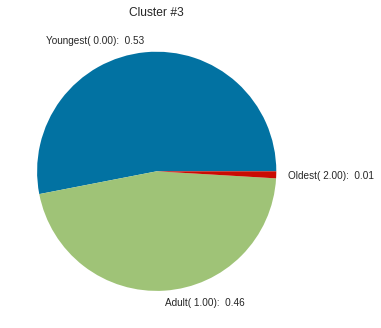

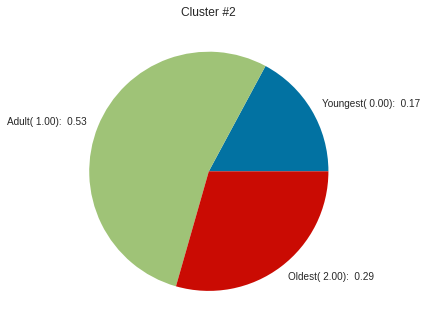

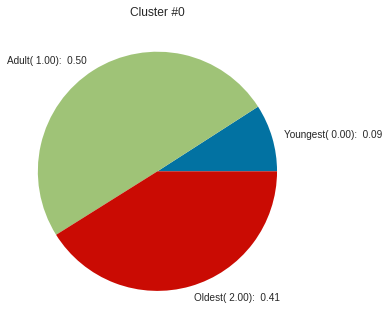

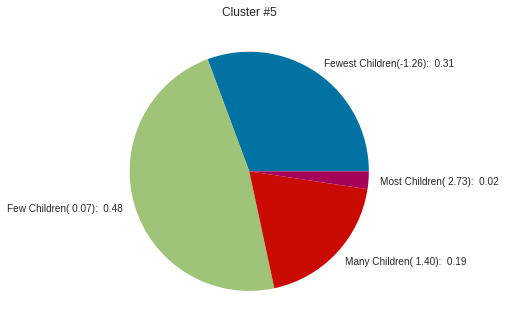

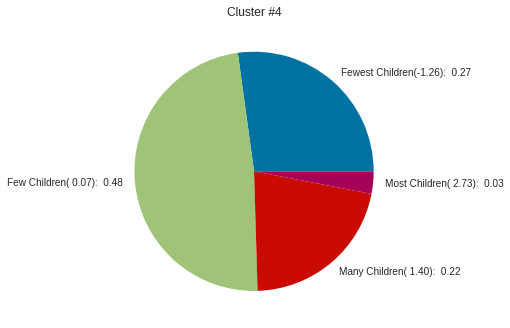

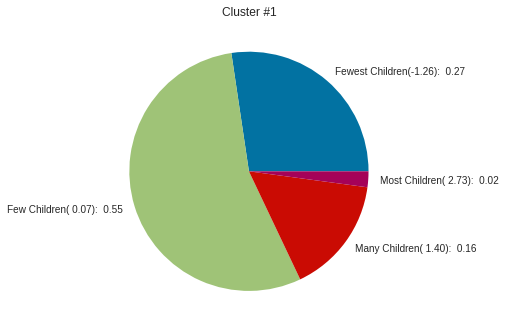

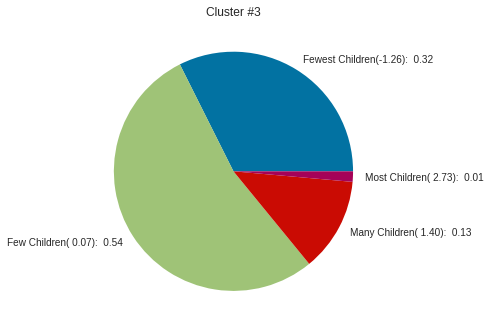

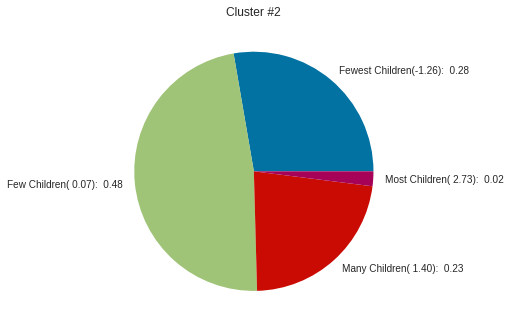

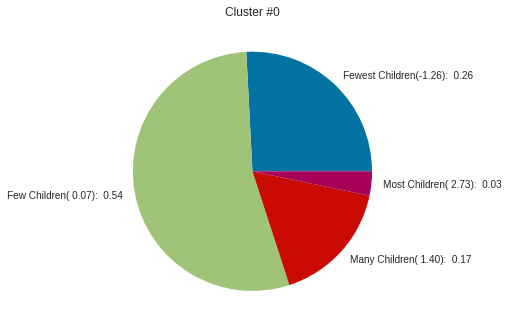

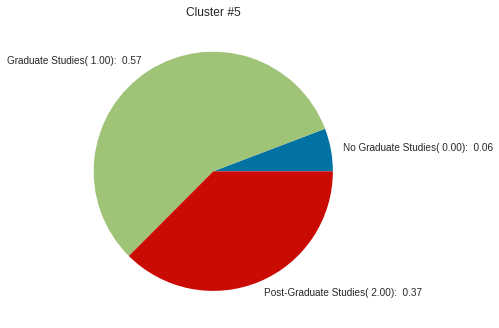

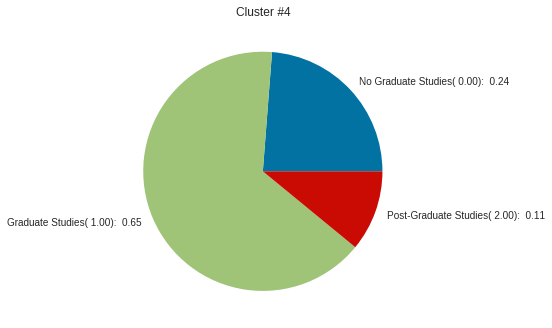

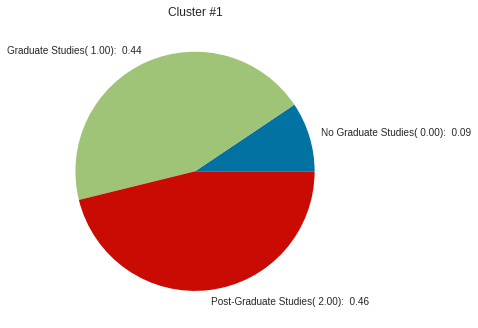

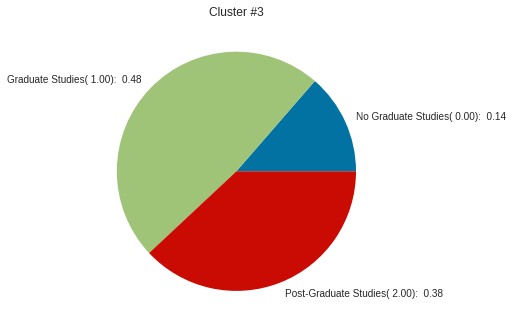

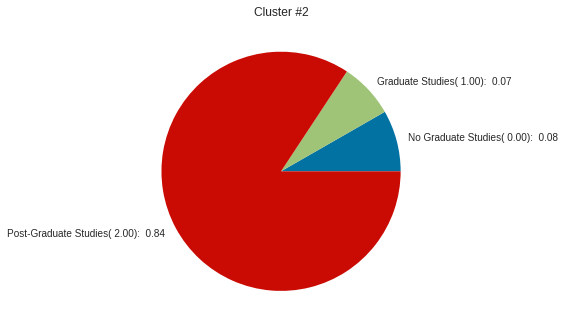

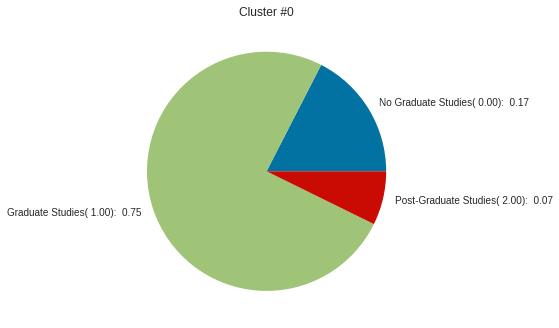

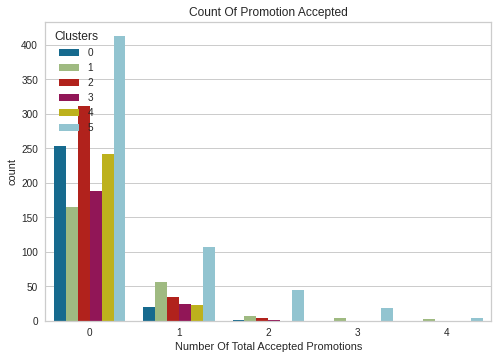

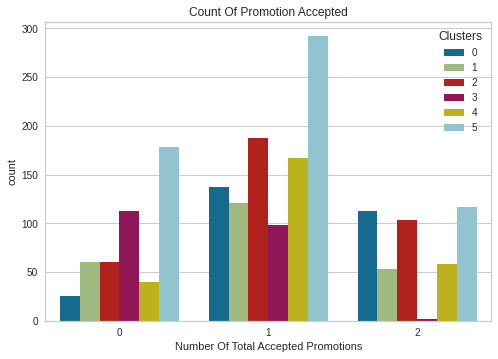

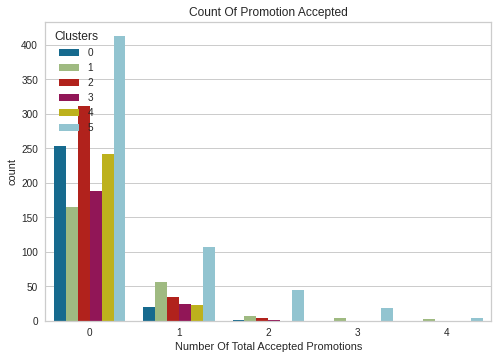

In [9]:
# PIE PLOTS
get_pie_graphs(cluster_df, full_df)
plt.show()

# # BOX PLOTS
# get_box_plots(cluster_df, full_df)
# plt.show()

# # SCATTER PLOTS
# get_scatter_plots(cluster_df, full_df)
# plt.show()


plt.figure()
pl = sns.countplot(x=full_df["Total_Promos"],hue=cluster_df['Clusters'])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()


plt.figure()
pl = sns.countplot(x=full_df["Age_Group"],hue=cluster_df['Clusters'])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()


plt.figure()
pl = sns.countplot(x=full_df["Total_Promos"],hue=cluster_df['Clusters'])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()